# Predicting Heart Disease

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white')
sns.set(style="whitegrid", color_codes=True)
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [79]:
df = pd.read_csv('Heart.csv')
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [80]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [81]:
#re-map column values
df.replace({'sex': {0:'female', 1: 'male'},
           'cp': {0: 'typical_angina_cp', 1: 'atypical_angina_cp', 2: 'non-anginal_pain_cp', 3: 'asymptomatic_cp'}, 
           'fbs': {0:'no_fbs', 1: 'yes_fbs'},
           'restecg':{0:'normal_restecg', 1:'ST-T_wave_abnormality_restecg', 2: 'left_ventricular_hypertrophy_restecg'},
           'exang': {0: 'no_exang', 1: 'yes_exang'},
           'slope': {0: 'upsloping_slope', 1: 'flat_slope', 2:'downsloping_slope'},
           'thal': {0: 'unknown_thal', 1: 'normal_thal', 2: 'fixed_defect_thal', 3: 'reversable_defect_thal'}}, inplace=True) 

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,asymptomatic_cp,145,233,yes_fbs,normal_restecg,150,no_exang,2.3,upsloping_slope,0,normal_thal,1
1,37,male,non-anginal_pain_cp,130,250,no_fbs,ST-T_wave_abnormality_restecg,187,no_exang,3.5,upsloping_slope,0,fixed_defect_thal,1
2,41,female,atypical_angina_cp,130,204,no_fbs,normal_restecg,172,no_exang,1.4,downsloping_slope,0,fixed_defect_thal,1
3,56,male,atypical_angina_cp,120,236,no_fbs,ST-T_wave_abnormality_restecg,178,no_exang,0.8,downsloping_slope,0,fixed_defect_thal,1
4,57,female,typical_angina_cp,120,354,no_fbs,ST-T_wave_abnormality_restecg,163,yes_exang,0.6,downsloping_slope,0,fixed_defect_thal,1


# Categorical EDA

In [82]:
categorical_df = df[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal','target']]

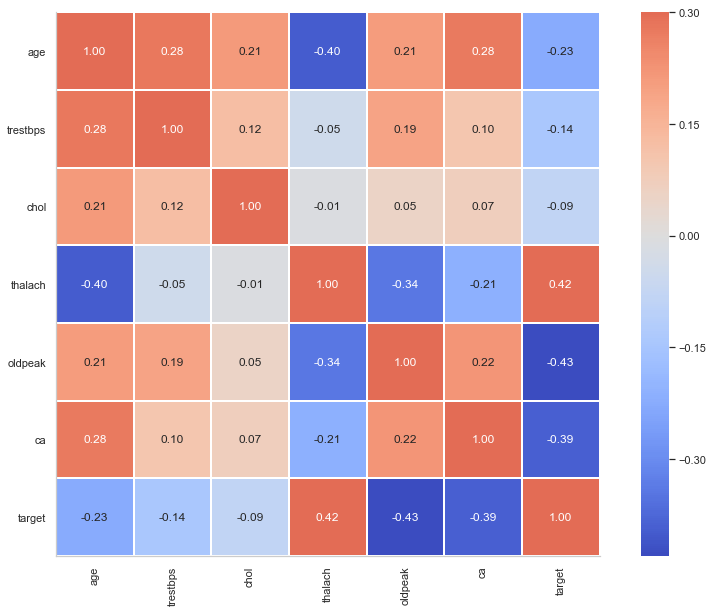

In [83]:
corr_cat = df.corr()
heatmap = sns.heatmap(corr_cat,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 1}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
heatmap.figure.set_size_inches(15,10)
    
plt.show()

In [84]:
def barplot(x_val, y_val='target',data=df):
    barplot = sns.barplot(x=x_val,y=y_val,data=data)
    barplot.set_xticklabels(labels = barplot.get_xticklabels(), rotation=45)
    return barplot

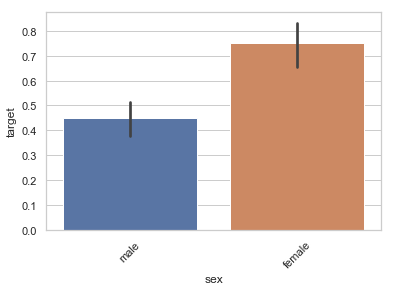

In [85]:
barplot('sex')

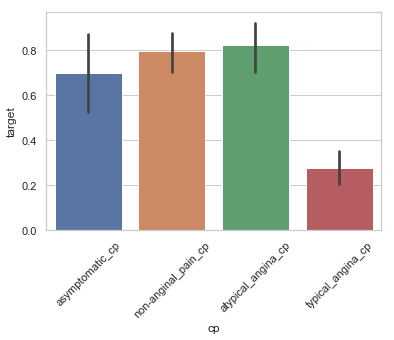

In [86]:
barplot('cp')

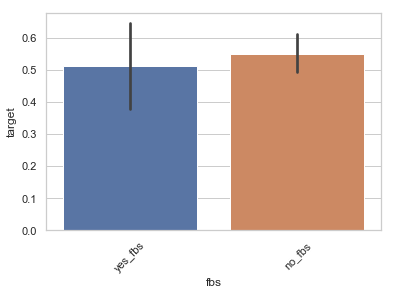

In [87]:
barplot('fbs')

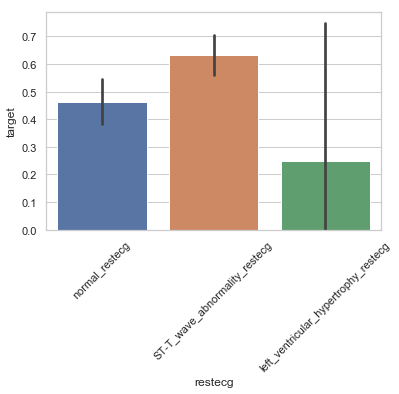

In [88]:
barplot('restecg')

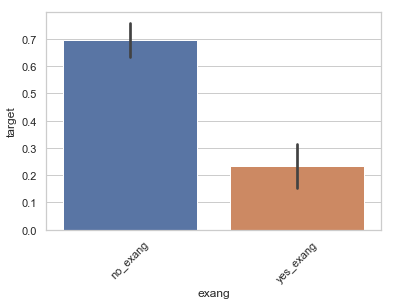

In [89]:
barplot('exang')

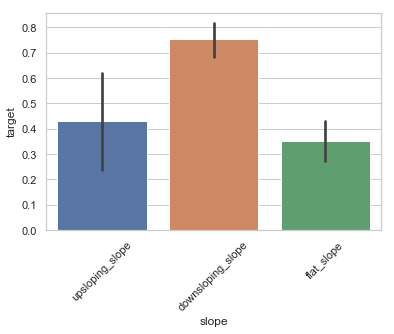

In [90]:
barplot('slope')

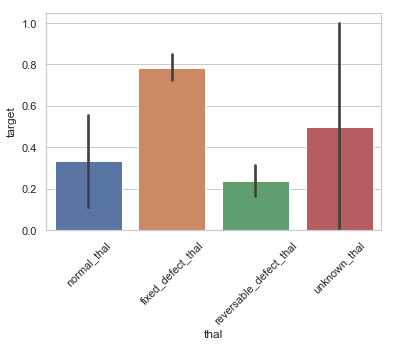

In [91]:
barplot('thal')

# Continuous EDA

In [93]:
continuous_df = df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'target']]

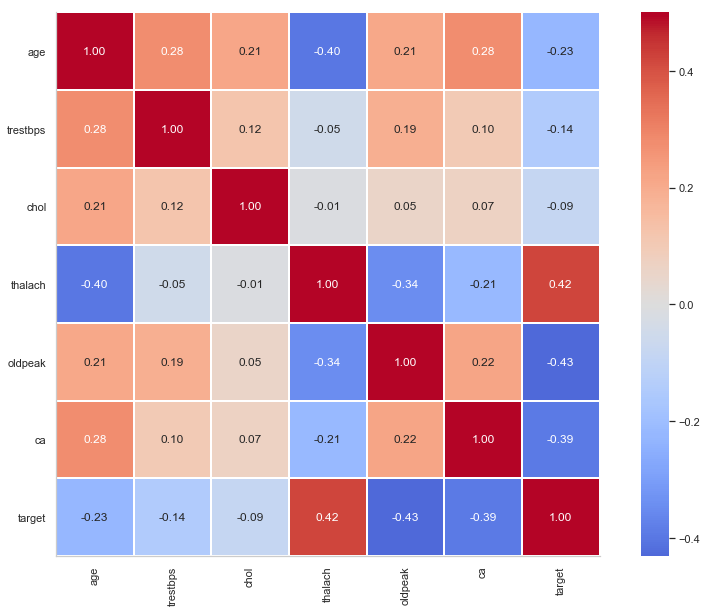

In [94]:
corr_con = continuous_df.corr()
heatmap = sns.heatmap(corr_con,  vmax=.5, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 1}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
heatmap.figure.set_size_inches(15,10)
    
plt.show()

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


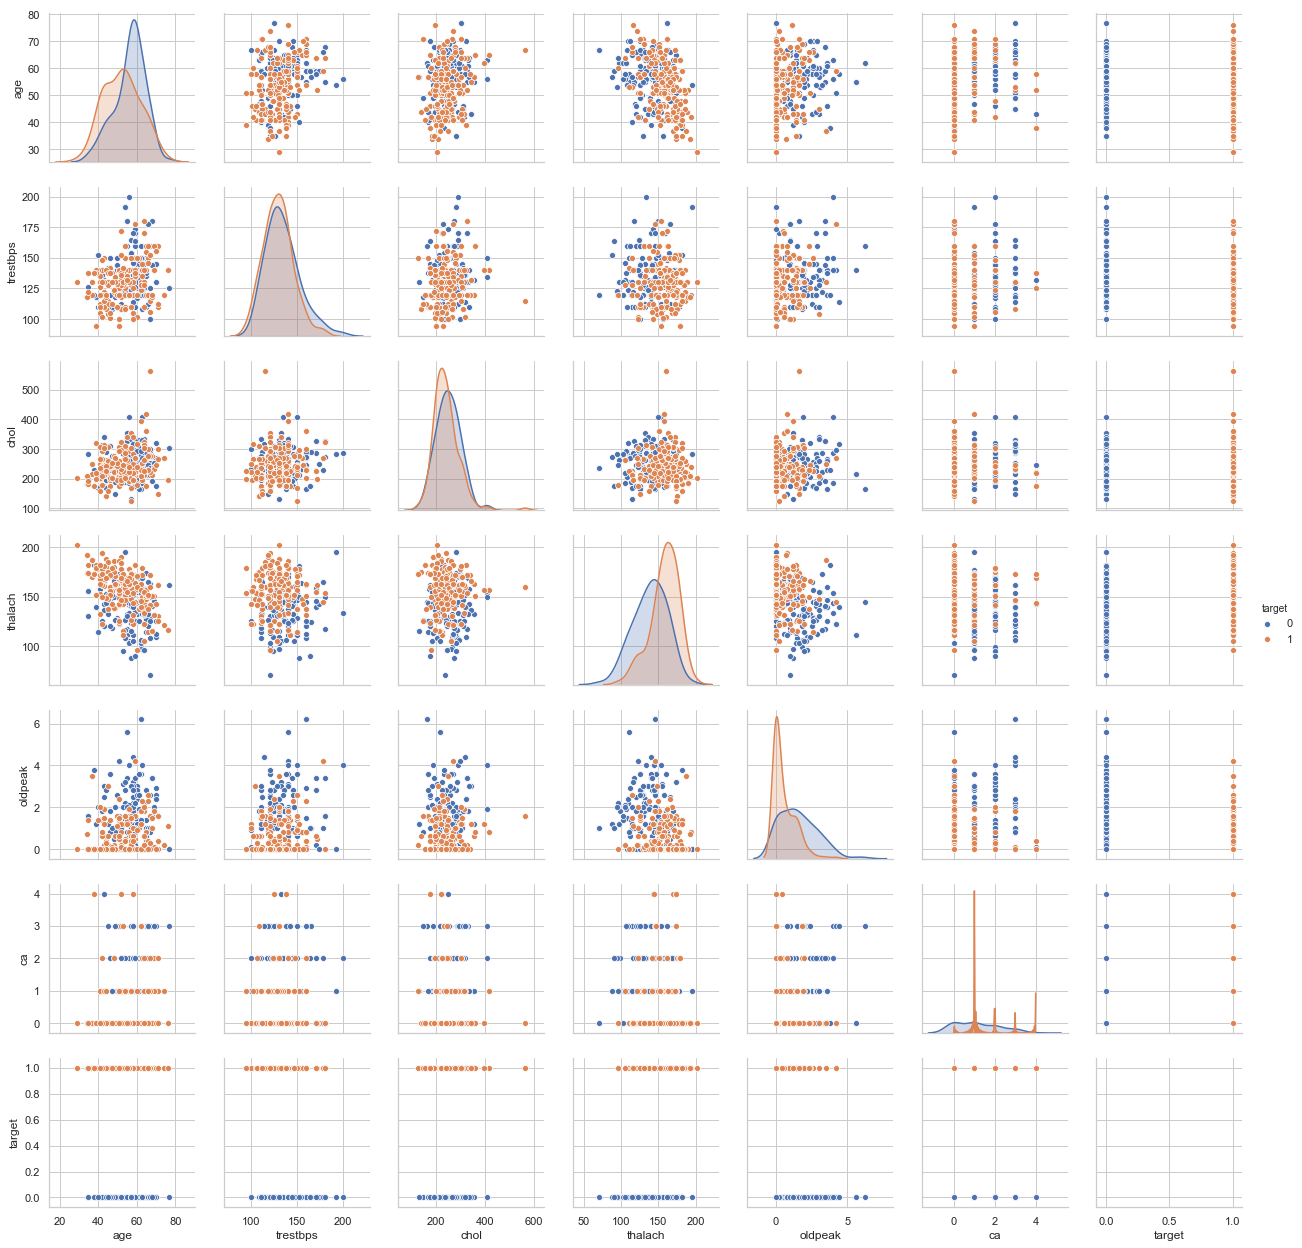

In [95]:
sns.pairplot(continuous_df, hue ='target')

In [96]:
def boxplot(x_val, y_val='target',data=df):
    boxplot = sns.boxplot(x=x_val,y=y_val,data=data, orient = 'h', saturation=1, width=.5, fliersize=5, whis=1)
    return boxplot

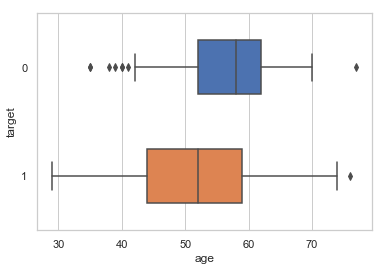

In [97]:
boxplot('age')

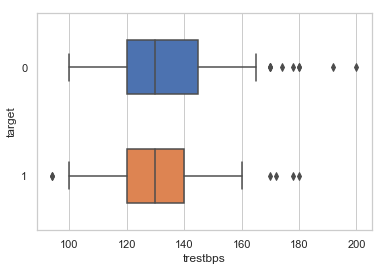

In [98]:
boxplot('trestbps')

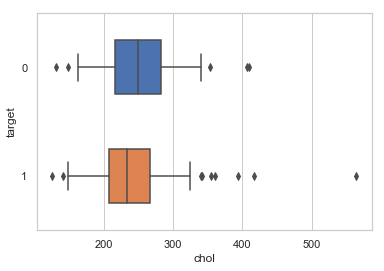

In [99]:
boxplot('chol')

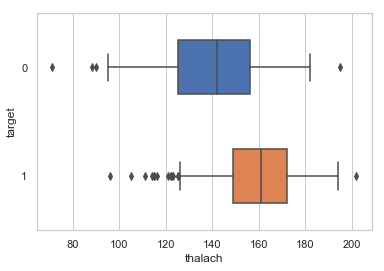

In [100]:
boxplot('thalach')

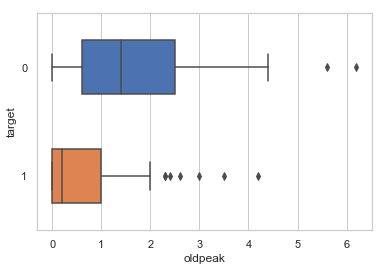

In [101]:
boxplot('oldpeak')

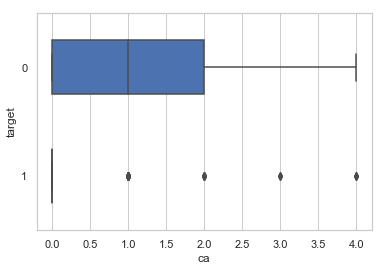

In [102]:
boxplot('ca')

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35493860>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1c354a5630>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35564668>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1c355a8748>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1c355ed7b8>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1c355d90f0>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35675710>]]


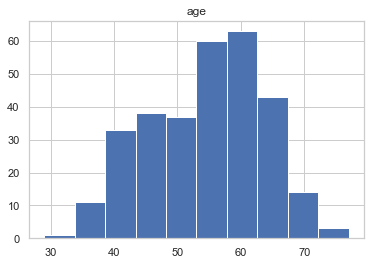

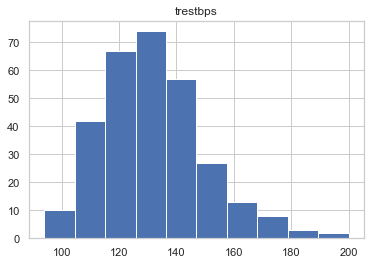

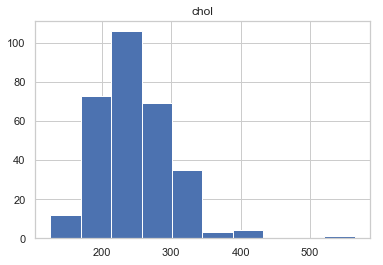

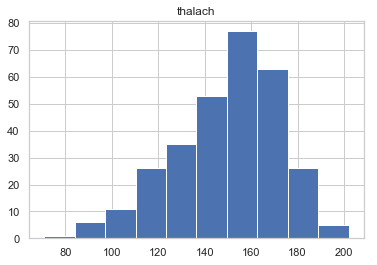

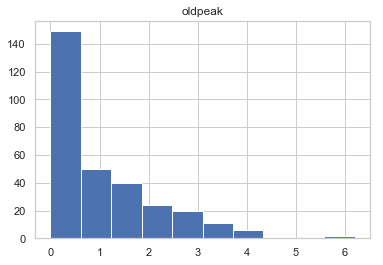

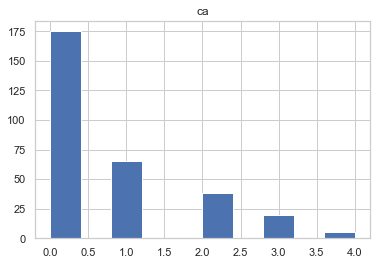

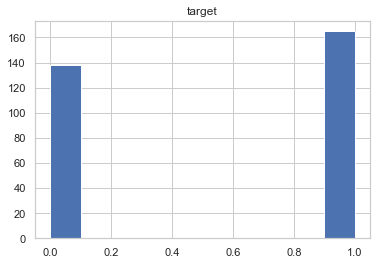

In [103]:
for feature in continuous_df:
    print(continuous_df.hist(feature))

 # Dummy Variables

In [104]:
#add rest of dummies
dummy_list = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
new_dfs = []
for feature in dummy_list:
    df_dummies = pd.get_dummies(df[feature])
    new_dfs.append(df_dummies)
    df.drop(feature, axis = 1, inplace =True)
    
dummy_df = pd.concat(new_dfs, axis = 1)
final_df = pd.concat([df, dummy_df], axis =1)

 # Logistic Regression

In [106]:
X = final_df.drop(['target', 'asymptomatic_cp',
'yes_fbs','normal_thal', 'no_fbs', 'upsloping_slope', 'left_ventricular_hypertrophy_restecg', 'unknown_thal', 'atypical_angina_cp'], axis=1)
y = final_df.target



logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.337041
         Iterations 12
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.511     
Dependent Variable:     target               AIC:                  238.2466  
Date:                   2020-04-27 13:22     BIC:                  301.3801  
No. Observations:       303                  Log-Likelihood:       -102.12   
Df Model:               16                   LL-Null:              -208.82   
Df Residuals:           286                  LLR p-value:          1.5361e-36
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         12.0000                                              
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


 # Logistic Regression Confusion Matrix

<function confusion_matrix at 0x1a1ebc9e18>


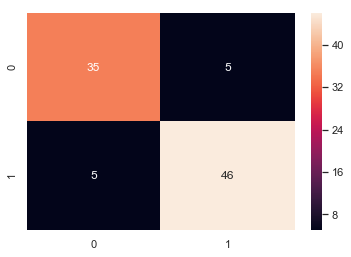

In [107]:
confusion_matrix_log = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

sns.heatmap(confusion_matrix_log, annot=True)

 # Logistic Regression ROC Curve

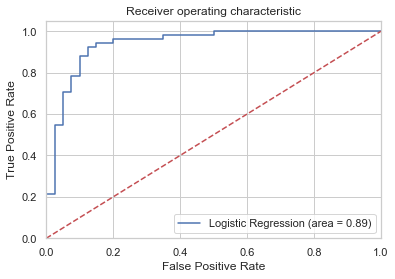

In [108]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

 # Random Forest


In [109]:
X= final_df.drop(['target', 'asymptomatic_cp',
'yes_fbs','normal_thal', 'no_fbs', 'upsloping_slope', 'left_ventricular_hypertrophy_restecg', 'unknown_thal', 'atypical_angina_cp'], axis =1)  # Features
y= final_df.target  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40) # 70% training and 30% test

#Create a Gaussian Classifier
forest=RandomForestClassifier(random_state = 1, n_estimators=200, max_depth = 25, min_samples_split =5)

#Train the model using the training sets
modelF= forest.fit(X_train,y_train)

y_predF =forest.predict(X_test)


#  Random Forest Grid Search

In [110]:
n_estimators = [50, 75, 100, 125, 150, 200]
max_depth = [3, 4, 5, 6, 7]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

bestF.best_params_

rf_best = bestF.best_estimator_

y_pred = rf_best.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   20.6s finished


Accuracy: 0.8791208791208791
             precision    recall  f1-score   support

          0       0.85      0.88      0.86        40
          1       0.90      0.88      0.89        51

avg / total       0.88      0.88      0.88        91



 # Random Forest Confusion Matrix

[[35  5]
 [ 6 45]]


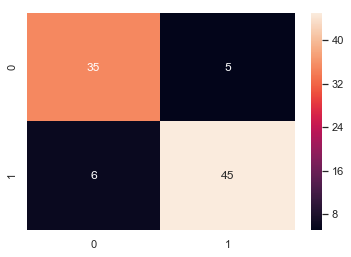

In [111]:
confusion_matrix_rf = confusion_matrix(y_test, y_pred)
print(confusion_matrix_rf)

sns.heatmap(confusion_matrix_rf, annot=True)

 # Random Forest ROC Curve

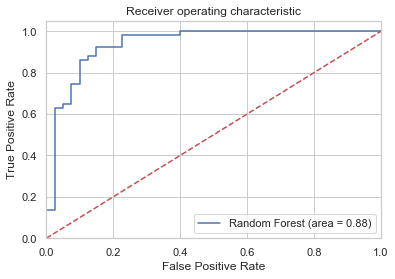

In [112]:
rf_roc_auc = roc_auc_score(y_test, forest.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('rf_ROC')
plt.show()

 # Gradient Boosting

In [113]:
# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.849
Accuracy score (test): 0.868

Learning rate:  0.1
Accuracy score (training): 0.858
Accuracy score (test): 0.868

Learning rate:  0.25
Accuracy score (training): 0.873
Accuracy score (test): 0.868

Learning rate:  0.5
Accuracy score (training): 0.906
Accuracy score (test): 0.868

Learning rate:  0.75
Accuracy score (training): 0.920
Accuracy score (test): 0.846

Learning rate:  1
Accuracy score (training): 0.948
Accuracy score (test): 0.791



 # Gradient Boosting Confusion Matrix

Confusion Matrix:
[[35  5]
 [ 7 44]]

Classification Report
             precision    recall  f1-score   support

          0       0.83      0.88      0.85        40
          1       0.90      0.86      0.88        51

avg / total       0.87      0.87      0.87        91



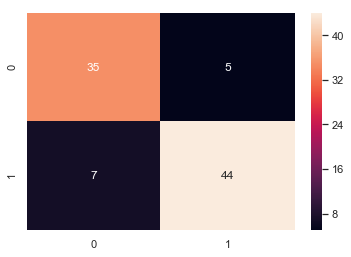

In [114]:
# Output confusion matrix and classification report of Gradient Boosting algorithm on validation set

gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
print()
print("Classification Report")
print(classification_report(y_test, predictions))

 # Gradient Boosting ROC Curve

Area under ROC curve = 0.93


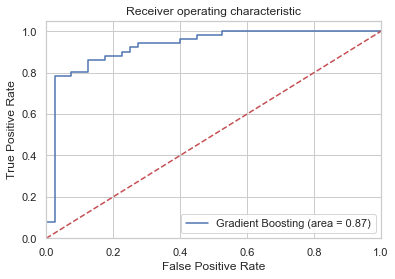

In [115]:
# ROC curve and Area-Under-Curve (AUC)

y_scores_gb = gb.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

gb_roc_auc = roc_auc_score(y_test, gb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.2f)' %gb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('gb_ROC')
plt.show()

 # Partial Dependence Plots

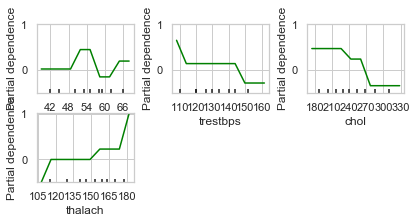

In [116]:
partial_dependence = plot_partial_dependence(gb,       
                                   features=[0, 1, 2, 3], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names= final_df.columns, # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

 # Feature Importance

No handles with labels found to put in legend.


fixed_defect_thal                0.121029
thalach                          0.110385
oldpeak                          0.105360
ca                               0.105325
typical_angina_cp                0.092306
age                              0.077417
chol                             0.067971
reversable_defect_thal           0.067867
trestbps                         0.066854
no_exang                         0.030803
downsloping_slope                0.029820
flat_slope                       0.020890
non-anginal_pain_cp              0.020241
male                             0.019047
yes_exang                        0.018665
female                           0.016625
normal_restecg                   0.015424
ST-T_wave_abnormality_restecg    0.013971
dtype: float64


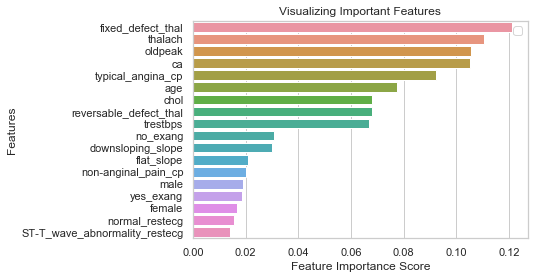

In [117]:
feature_names = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca',
       'female', 'male', 'non-anginal_pain_cp',
       'typical_angina_cp', 'ST-T_wave_abnormality_restecg', 'normal_restecg', 'no_exang', 'yes_exang', 'downsloping_slope',
       'flat_slope', 'fixed_defect_thal', 'reversable_defect_thal']
target_names = ['target']
feature_imp = pd.Series(forest.feature_importances_,index=feature_names).sort_values(ascending=False)
print(feature_imp)                       
                                            
                        
                        

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()